1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [11]:
# Necssary libraries
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import DecisionTreeRegressor
from __future__ import print_function
import os
import subprocess
from IPython.display import Image
import pydotplus
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import pylab
from sklearn import svm
from sklearn.linear_model import Ridge
import re
import pylab as plt
import seaborn
import numpy.random as nprnd
pd.set_option('display.max_columns', 500)
%matplotlib inline
import random

# Load in the dataset
df = pd.read_csv("https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv")
df.head()

,Unnamed: 0,default,student,balance,income
0,1,No,No,729.526495,44361.625074
1,2,No,Yes,817.180407,12106.134700
2,3,No,No,1073.549164,31767.138947
3,4,No,No,529.250605,35704.493935
4,5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [2]:
df = df.replace(['Yes'], 1)
df = df.replace(['No'], 0) 
df.head()

,Unnamed: 0,default,student,balance,income
0,1,0,0,729.526495,44361.625074
1,2,0,1,817.180407,12106.134700
2,3,0,0,1073.549164,31767.138947
3,4,0,0,529.250605,35704.493935
4,5,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

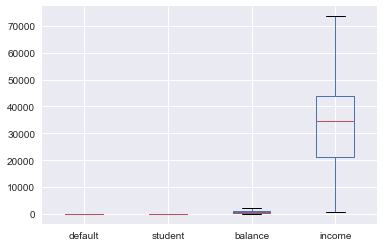

In [3]:
df[['default', 'student', 'balance', 'income']].boxplot()

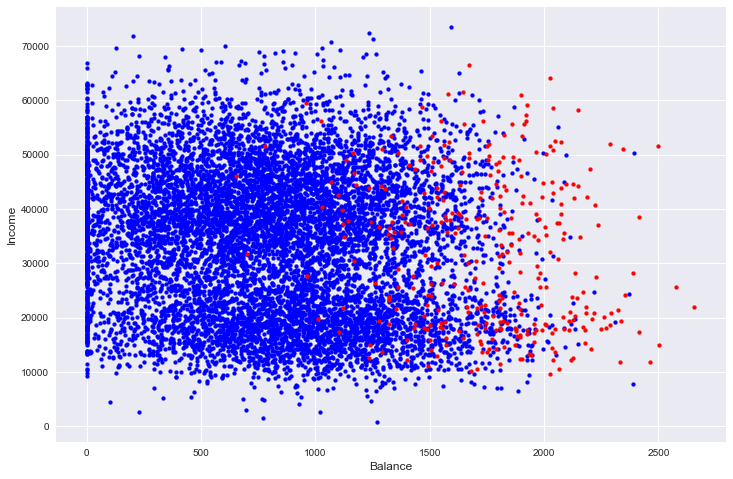

In [4]:
balance_yes=[]
income_yes=[]
balance_no=[]
income_no=[]
for index, row in df.iterrows():
    if row['default'] == 1:
        balance_yes.append(row['balance'])
        income_yes.append(row['income'])
    else:
        balance_no.append(row['balance'])
        income_no.append(row['income'])

plt.figure(figsize=(12,8))
plt.scatter(balance_no, income_no, color='b', s=15)
plt.scatter(balance_yes, income_yes, color='r', s=15)
plt.xlabel('Balance', fontsize=12)
plt.ylabel('Income', fontsize=12)

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

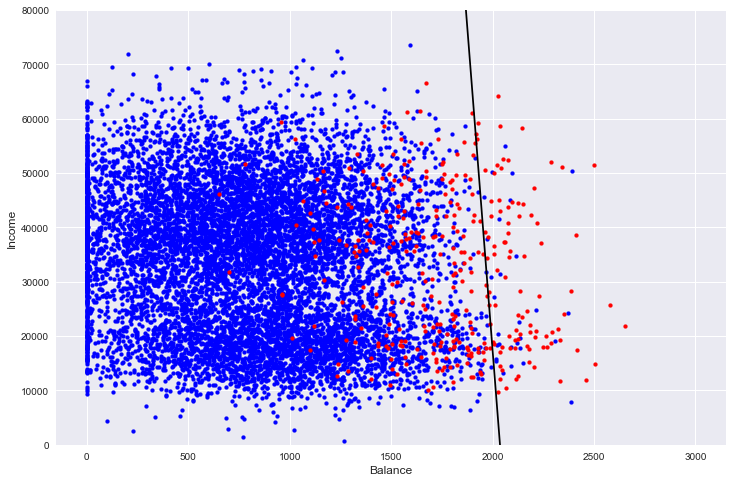

Area under the ROC curve : 0.960620


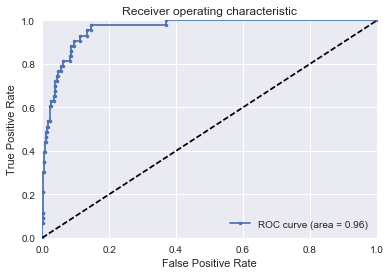

In [5]:
# Train a model using LogisticRegression based solely on the balance and income variables
X = df[['balance', 'income']]
y = df['default']
log_reg = LogisticRegression(C=0.1, penalty='l1')
log_reg.fit(X, y)

# Plot the decision boundary
plt.figure(figsize=(12,8))
plt.scatter(balance_no, income_no, color='b', s=15)
plt.scatter(balance_yes, income_yes, color='r', s=15)
plt.xlabel('Balance', fontsize=12)
plt.ylabel('Income', fontsize=12)
w0 = log_reg.intercept_
w1, w2 = log_reg.coef_[0]
xx = np.linspace(0,3000,2000)
plt.plot(xx, (-w0-w1*xx)/w2, c='black')
plt.ylim(0,80000)
plt.show()

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

The coefficients are: [-0.00470615  0.06417401  0.00265612]


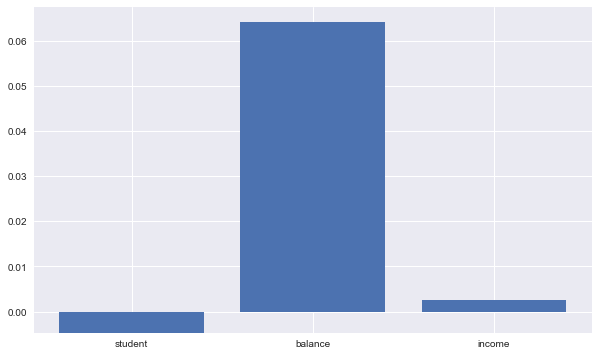

Area under the ROC curve : 0.962209


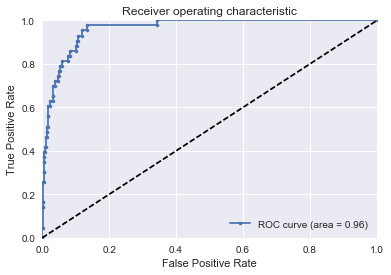

In [6]:
df.head()
X = df[['student', 'balance', 'income']]
y = df['default']
scaler = StandardScaler()
X = X.as_matrix().astype(np.float)
X = scaler.fit_transform(X)
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X, y)
print("The coefficients are:", ridge_reg.coef_)
plt.figure(figsize=(10,6))
plt.bar([0,1,2], ridge_reg.coef_)
plt.xticks([0,1,2], ("student", "balance", "income"))
plt.show()

# Plots ROC
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,penalty='l2')
generate_ROCplot(fpr,tpr,'Ridge',roc_auc)

$\bf{Comments:}$
We can see that the area under the ROC curve does not change too much, but with a slight increase. Thus the variable student does not improve the performance too much.


6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

Area under the ROC curve : 0.962095


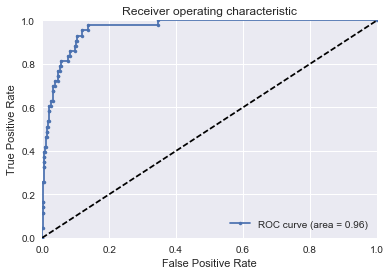

Area under the ROC curve : 0.951769


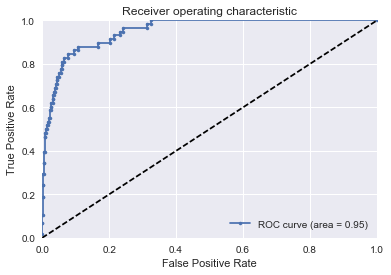

Area under the ROC curve : 0.940426


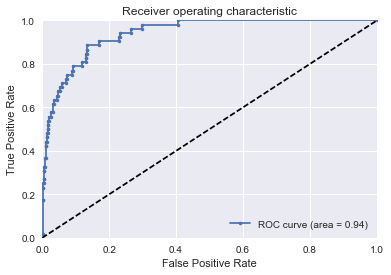

Area under the ROC curve : 0.952667


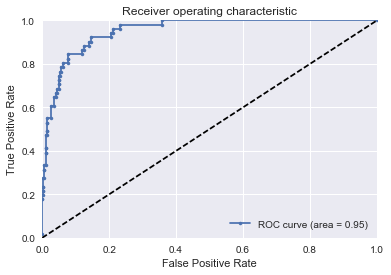

Area under the ROC curve : 0.934079


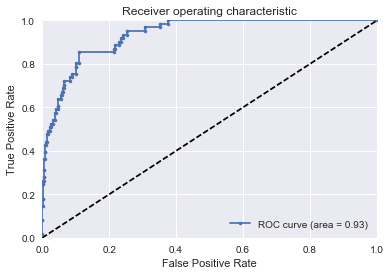

In [7]:
# Computes the AUC ROC of the classifier.
def generate_auc(X,y,s,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = s
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

# We use different random state and plot the ROC curve
for s in [0, 5, 10, 20, 50]:
    fpr,tpr,roc_auc, thresholds = generate_auc(X,y,s,LogisticRegression,C=0.1,penalty='l2')
    generate_ROCplot(fpr,tpr,'Ridge',roc_auc)


$\bf {Comments: }$
We can see that all five AUC ROC values are around 95%, thus we conclude that the model we built in part 5 is robust.

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

Area under the ROC curve : 0.913087


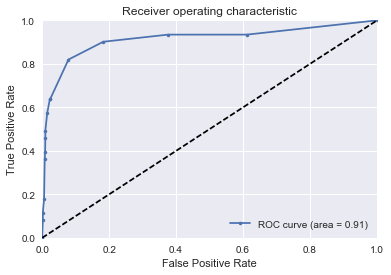

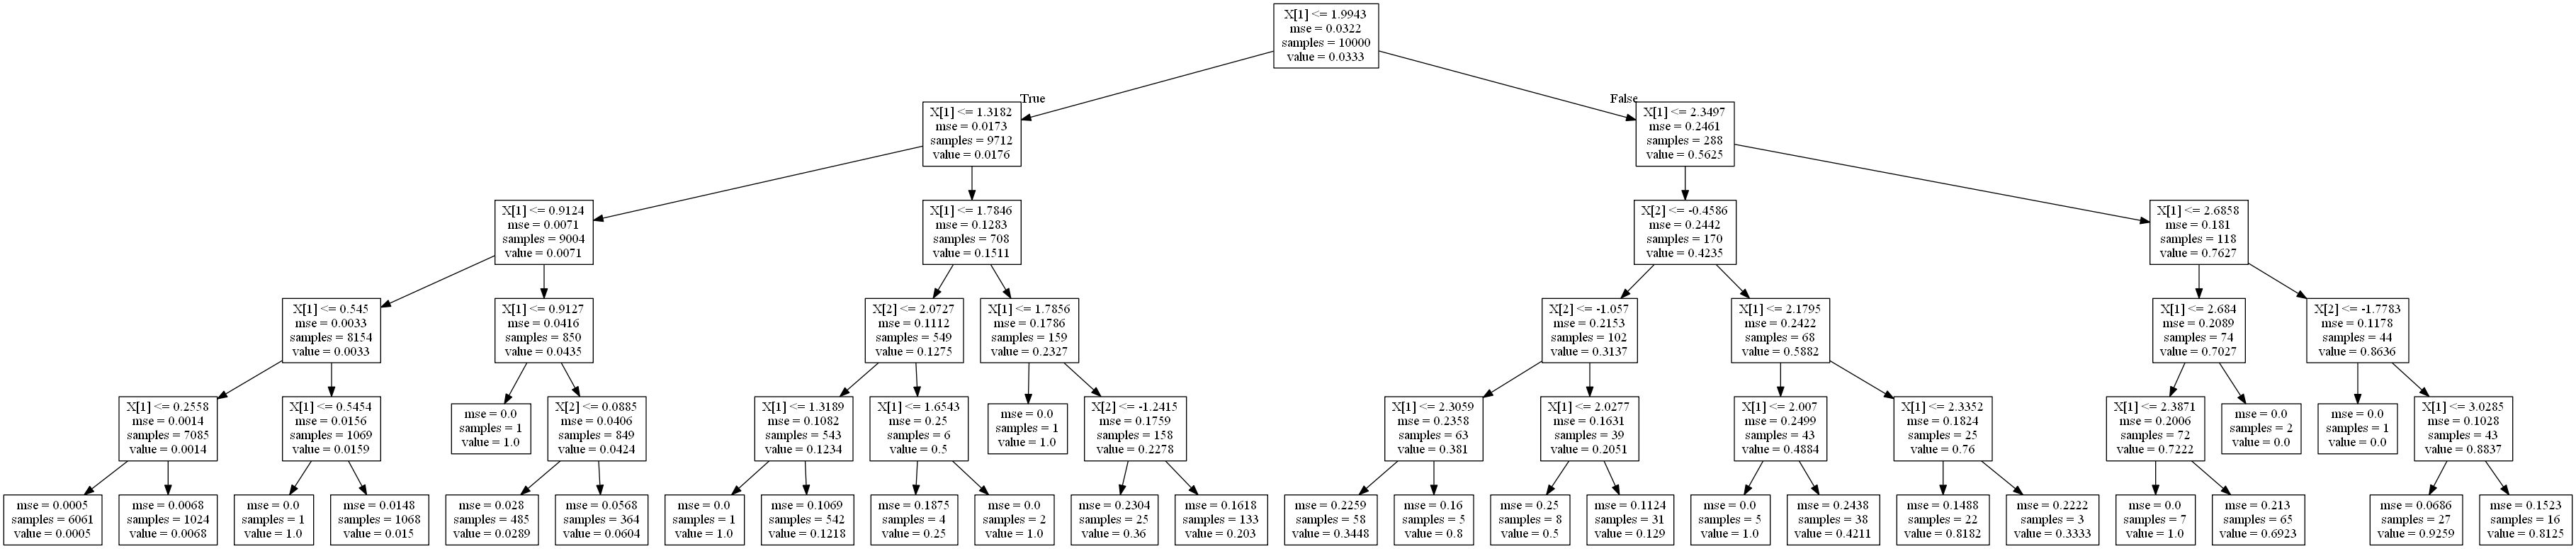

In [8]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

# Calculate AUC ROC and plot ROC curve
fpr,tpr,roc_auc,thresholds = generate_auc(X,y,42,DecisionTreeClassifier,max_depth=5)
roc_auc = auc(fpr, tpr)
generate_ROCplot(fpr,tpr,'LR',roc_auc)

# Plot the tree
regr_5 = DecisionTreeRegressor(max_depth=5)
regr_5.fit(X, y)
dt=DecisionTreeRegressor(max_depth=5)
visualize_tree(regr_5, feature_names=['x'])
dot_data=export_graphviz(regr_5, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

With with maximum depth 5, the decision tree achieve an AUC ROC value of 0.913, which is slightly ower than that of Ridge and logistic regression models. The reason might be that the maximum depth we used here is not the optimal one.

8) Find the optimal decision tree depth and compute the AUC ROC. 

The optimal decision tree depth is 3


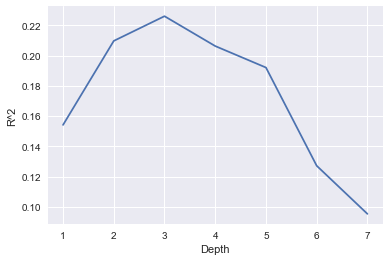

In [9]:
# Fit regression model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,8)
for n in depths:
    regr = DecisionTreeRegressor(max_depth=n)
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    scores.append(regr.score(X_test,y_test))
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,scores)
test_errors=scores
n_opt=depths[np.argmax(scores)]
print("The optimal decision tree depth is", n_opt)

Area under the ROC curve : 0.953918


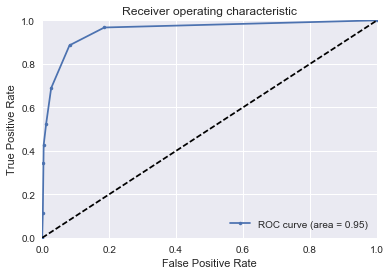

In [10]:
# Calculate AUC ROC and plot roc
fpr,tpr,roc_auc,thresholds = generate_auc(X,y,42,DecisionTreeClassifier,max_depth=n_opt)
generate_ROCplot(fpr,tpr,'LR',roc_auc)